<a href="https://colab.research.google.com/github/kadenpoore/12/blob/main/Assignments/Scripts/advise_invest_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdviseInvest

### Outline

Our Goals with this Project:

1. Import and review the data
2. Perform EDA and Clean Data
3. Fit a model
4. Test the accuracy of the model
6.  Use the model to predict on a new dataset (without the target)

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/Scripts/advise_invest_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AdviseInvest Data Dictionary

Variable    |Description |Type    |Code
---- | ------- | ------ | -----
Answered       | Customer response |    Binary    |0: customer did not answer scheduled call; 1: customer answered scheduled call
Income       | Customer income in US dollars|	Numeric
Female       | Customer gender|	Binary	0: female; 1: male
Age	         | Age in years|	Numeric
Job          | Nature of job|	Categorical|	0 : unemployed; 1 : entry level position; 2 : midlevel position; 3 : management/ self-employed/ highly qualified employee/ officer
Num_dependents | Number of people for whom the customer provides maintenance|	Numeric
Rent	| Customer rents	|Binary	|0: no; 1: yes
Own_res	| Customer owns residence|	Binary|	0: no; 1: yes
New_car| Recent new car purchase	|Binary|	New car purchase in the last 3 months: 0: no, 1: yes
Chk_acct | Checking account status	|Categorical|	0 : no checking account; 1: checking < 200 USD; 2 : 200 < checking < 2000 USD; 3: 2000 < checking < 35000 USD; 4: >= 3500 USD
Sav_acct	| Average balance in savings account|	Categorical|	0 : no savings account; 1 : 100 <= savings < 500 USD; 2 : 500 <= savings < 2000 USD; 3 : 2000 < savings < 35000 USD; 4: >= 3500 USD
Num_accts	| Number of accounts owned by customer	|Numeric
Mobile	| Mobile phone	|Binary	|0: customer provided non‐mobile phone for follow‐up call; 1: customer provided mobile phone for follow‐up call
Product| Type of product purchased after conversation with sales rep	|Categorical|	0: customer did not answer call; 1: customer answered but did not purchase a product; 2: customer answered and purchased Beginner plan; 3: customer answered and purchased Intermediate plan; 4: customer answered and purchased Advanced plan



### Load Libraries

In this class we will be using
- Pandas
- Scikitlearn
- Matplotlib


In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


## Step 1: Initial Data Understanding

 - Import data from the AdviseInvest historical dataset into a dataframe (in GitHub go to Assignments > DataSets)
 - Describe or profile the dataframe
 - Look for any outliers, missing values, or duplicates

In [2]:
# Define the raw GitHub URL
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Assignments/DataSets/adviseinvest_new_customer_data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())

   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0         1   
1   30510       0   54    2               1     0        1        0         0   
2   12880       0   48    2               2     0        1        0         0   
3   15530       0   44    2               1     0        1        0         0   
4   46230       0   40    3               1     0        1        0         3   

   sav_acct  num_accts  mobile customer_id  
0         0          3       0       H1597  
1         0          2       0       P1446  
2         1          4       0       E1492  
3         0          2       0       W5143  
4         1          2       0       W4927  


In [3]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()

# Check for outliers using the IQR method
numeric_cols = df.select_dtypes(include=['number'])  # Select only numeric columns
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Outliers are values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).sum()

# Print the results
print("Missing Values:\n", missing_values[missing_values > 0])
print("\nNumber of Duplicates:", duplicates)
print("\nOutliers per Numeric Column:\n", outliers[outliers > 0])

Missing Values:
 Series([], dtype: int64)

Number of Duplicates: 0

Outliers per Numeric Column:
 income             67
female             50
age                26
job               383
num_dependents    139
rent              213
new_car           227
mobile            103
dtype: int64


In [ ]:
#Describe the data

## Step 2: Data Preparation

### 2.1: Data Cleanup
- Remove any variables that are not relevant to our analysis (if they relate to activity after the answer).
- Clean up the data and put it in a new datafram named "df_clean"


In [4]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_clean = df[~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)]

# Display the number of rows before and after removing outliers
print(f"Original dataset size: {df.shape[0]} rows")
print(f"Cleaned dataset size: {df_clean.shape[0]} rows")


Original dataset size: 1000 rows
Cleaned dataset size: 277 rows


In [5]:
# Display column names to verify correct names
print("Columns in dataset:", df.columns.tolist())

# Identify columns to drop based on redundancy or low value
columns_to_drop = [
    'Own_res',  # Redundant since 'Rent' provides similar info (if you rent, you don’t own)
    'Chk_acct',  # Checking account status may not be relevant for analysis
    'Mobile',  # Whether a phone is mobile or not is unlikely to affect financial decisions
    'New_car'  # Recent car purchase may not be useful for investment advice
]

# Drop only the columns that exist in the dataset
df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Display the remaining columns
print("Remaining columns after cleaning:", df_clean.columns.tolist())


Columns in dataset: ['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res', 'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile', 'customer_id']
Remaining columns after cleaning: ['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res', 'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile', 'customer_id']


In [6]:
from sklearn.preprocessing import MinMaxScaler


# Step 1: Remove duplicates
df = df.drop_duplicates()

# Step 2: Handle missing values
# Drop rows where all values are missing
df = df.dropna(how='all')

# Fill missing values appropriately
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # Numeric columns
        df[col].fillna(df[col].median(), inplace=True)
    else:  # Categorical and object columns
        df[col].fillna(df[col].mode()[0], inplace=True)

# Step 3: Convert categorical columns to appropriate types
categorical_columns = ['Job', 'Chk_acct', 'Sav_acct', 'Product']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype(str)  # Ensure categorical columns are strings

# Step 4: Convert binary columns to integer type (0/1)
binary_columns = ['Answered', 'Female', 'Rent', 'Own_res', 'New_car', 'Mobile']
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].astype(int)

# Step 5: Normalize numeric columns using Min-Max Scaling
numeric_columns = ['Income', 'Age', 'Num_dependents', 'Num_accts']
scaler = MinMaxScaler()

# Ensure columns exist before applying scaler
existing_numeric_cols = [col for col in numeric_columns if col in df.columns]
if existing_numeric_cols:
    df[existing_numeric_cols] = scaler.fit_transform(df[existing_numeric_cols])

# Display cleaned dataset summary
print("Data after cleaning:")
print(df.info())
print(df.head())

# Optional: Check for any column names with leading or trailing spaces
print("Column names with possible spaces:")
print([col for col in df.columns if col != col.strip()])



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   income          1000 non-null   int64 
 1   female          1000 non-null   int64 
 2   age             1000 non-null   int64 
 3   job             1000 non-null   int64 
 4   num_dependents  1000 non-null   int64 
 5   rent            1000 non-null   int64 
 6   own_res         1000 non-null   int64 
 7   new_car         1000 non-null   int64 
 8   chk_acct        1000 non-null   int64 
 9   sav_acct        1000 non-null   int64 
 10  num_accts       1000 non-null   int64 
 11  mobile          1000 non-null   int64 
 12  customer_id     1000 non-null   object
dtypes: int64(12), object(1)
memory usage: 101.7+ KB
None
   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0       

<ipython-input-6-f9c795a409a9>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-6-f9c795a409a9>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

### 2.2: Standardize variables

 - Change "answered" to yes/no and make it categorical
 - Convert any variables that should be an integer into an integer

In [7]:
# Create the 'answered' column based on the 'mobile' column (proxy for answered)
df['answered'] = df['mobile'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Convert 'answered' to categorical (optional)
df['answered'] = pd.Categorical(df['answered'])

# Display the updated dataframe with 'answered' column
print(df[['mobile', 'answered']].head())



   mobile answered
0       0       No
1       0       No
2       0       No
3       0       No
4       0       No


In [8]:
# Convert the 'answered' column from categorical (Yes/No) to integers (1/0)
df['answered'] = df['answered'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the updated dataframe with 'answered' as integer
print(df[['mobile', 'answered']].head())

   mobile answered
0       0        0
1       0        0
2       0        0
3       0        0
4       0        0


### 2.3 Convert variables to categorical

- Find at least 8 variables that would be appropriate to convert to categories

In [9]:
# List of variables to convert to categorical
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'rent', 'own_res', 'new_car', 'mobile', 'product']

# Convert these columns to categorical
for col in categorical_columns:
    if col in df.columns:
        df[col] = pd.Categorical(df[col])

# Display the updated dataframe info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   income          1000 non-null   int64   
 1   female          1000 non-null   int64   
 2   age             1000 non-null   int64   
 3   job             1000 non-null   category
 4   num_dependents  1000 non-null   int64   
 5   rent            1000 non-null   category
 6   own_res         1000 non-null   category
 7   new_car         1000 non-null   category
 8   chk_acct        1000 non-null   category
 9   sav_acct        1000 non-null   category
 10  num_accts       1000 non-null   int64   
 11  mobile          1000 non-null   category
 12  customer_id     1000 non-null   object  
 13  answered        1000 non-null   category
dtypes: category(8), int64(5), object(1)
memory usage: 56.0+ KB
None


In [10]:
# Create the 'answered' column based on the 'mobile' column (proxy for answering)
df['answered'] = df['mobile'].apply(lambda x: 1 if x == 1 else 0)

# Display the updated dataframe with 'answered' column
print(df[['mobile', 'answered']].head())

  mobile answered
0      0        0
1      0        0
2      0        0
3      0        0
4      0        0


# Step 3: Exploratory Data Analysis (EDA)
- Explore the relationships between the target and independent variables
- Create at least five charts to show the relationships, using different chart types that are approriate to the analysis
- Ensure that all charts are clearly labeled and formatted

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

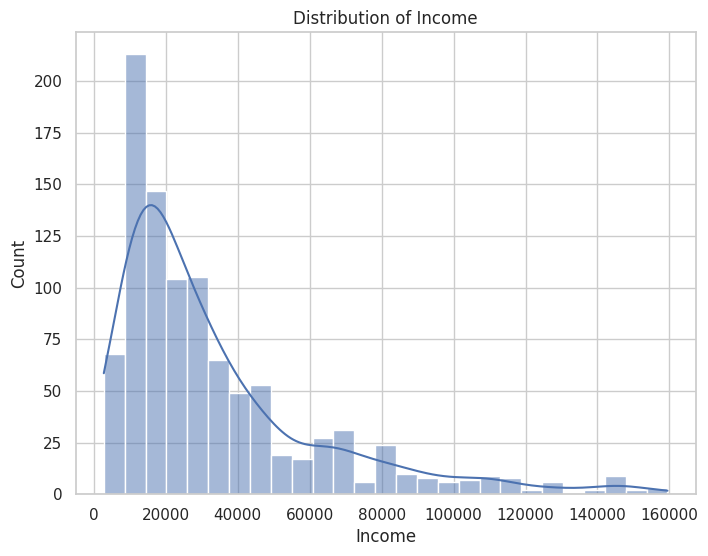

In [31]:
# prompt: create a chart

import matplotlib.pyplot as plt
# Assuming 'df' is your DataFrame (from the previous code)

# Chart 1: Distribution of Income
# Changed 'Income' to 'income' to match the actual column name
plt.figure(figsize=(8, 6))
sns.histplot(df['income'], kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt

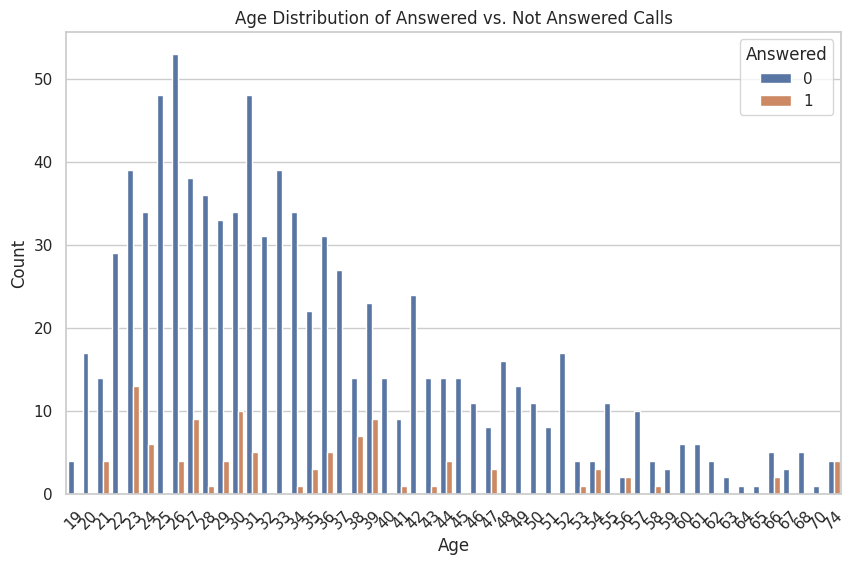

In [33]:
# prompt: create a chart showing ages of answered and didn't

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame from the previous code

# Create a countplot of 'age' (lowercase) grouped by 'answered'
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='answered', data=df)  # Changed 'Age' to 'age'
plt.title('Age Distribution of Answered vs. Not Answered Calls')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Answered')
plt.show()

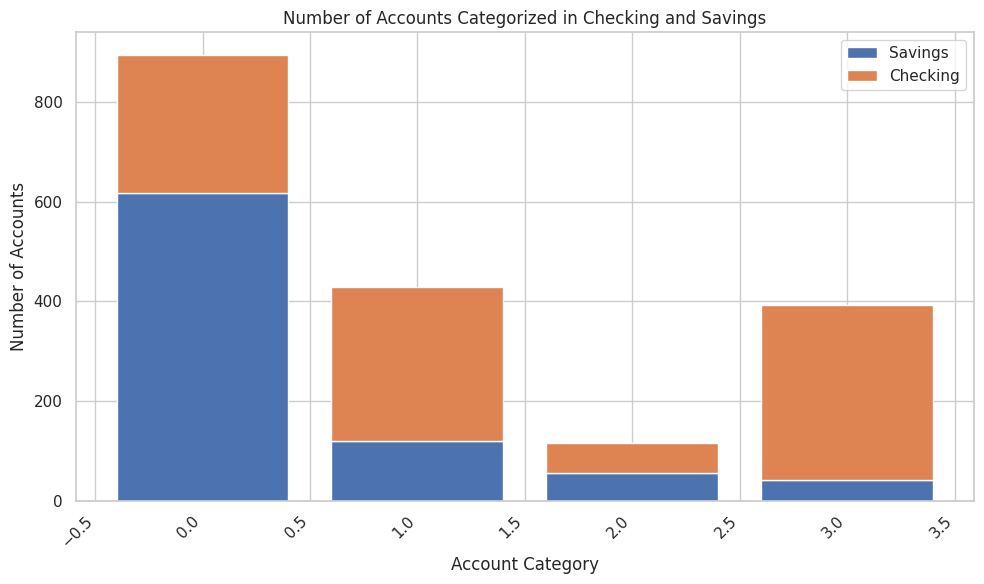

In [35]:
# prompt: create a chart showing the number of accounts categorized in checking and savings

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame from the previous code

# Count the occurrences of each 'sav_acct' category
savings_counts = df['sav_acct'].value_counts()

# Count the occurrences of each 'chk_acct' category
checking_counts = df['chk_acct'].value_counts()

# Get the common categories between savings and checking accounts
common_categories = savings_counts.index.intersection(checking_counts.index)

# Filter the counts to include only common categories
savings_counts = savings_counts.loc[common_categories]
checking_counts = checking_counts.loc[common_categories]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(savings_counts.index, savings_counts.values, label='Savings')
plt.bar(checking_counts.index, checking_counts.values, label='Checking', bottom=savings_counts.values)  # Now, shapes should match

# Customize the chart
plt.xlabel('Account Category')
plt.ylabel('Number of Accounts')
plt.title('Number of Accounts Categorized in Checking and Savings')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

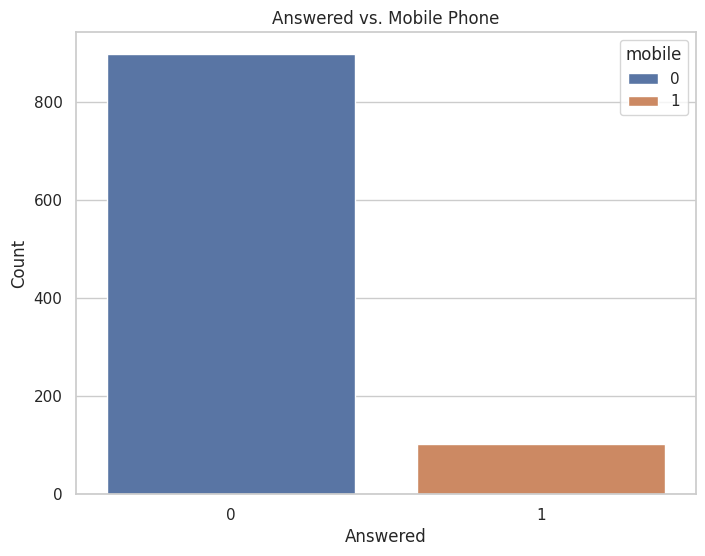

In [37]:
# prompt: create a chart showing answered and mobile

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains 'answered' and 'mobile' columns.
# Create the plot
plt.figure(figsize=(8, 6))
sns.countplot(x='answered', hue='mobile', data=df)
plt.title('Answered vs. Mobile Phone')
plt.xlabel('Answered')
plt.ylabel('Count')
plt.show()


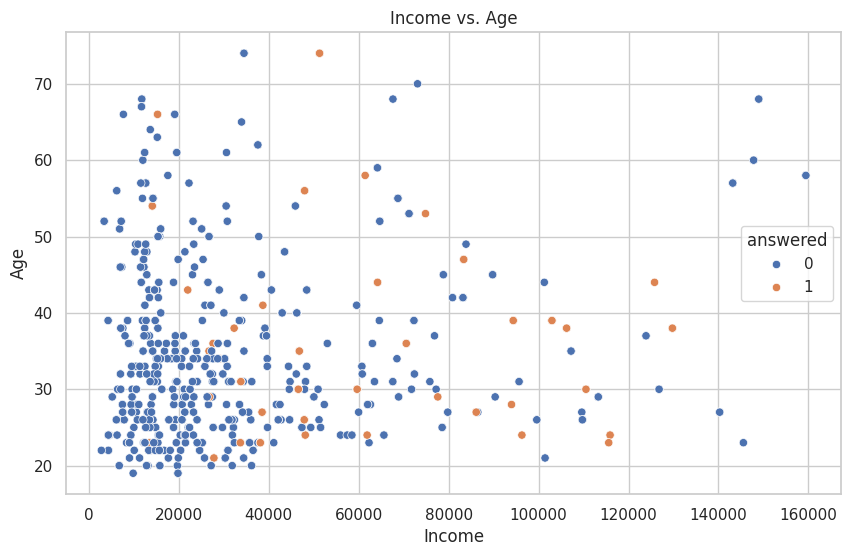

In [39]:
# prompt: create a chart showing the relationship between 2 important variables

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and contains 'income' and 'age' columns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='income', y='age', data=df, hue='answered') # Replace 'answered' with your target variable if different
plt.title('Income vs. Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()


In [117]:
from google.colab import drive
drive.mount('/content/drive')

!jupyter nbconvert --to html "advise_invest_template-5.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook advise_invest_template-5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 1511080 bytes to advise_invest_template-5.html


In [41]:
import pandas as pd

# Assuming your DataFrame is called df
df['answered'] = df['answered'].map({0: 'no', 1: 'yes'}).astype('category')


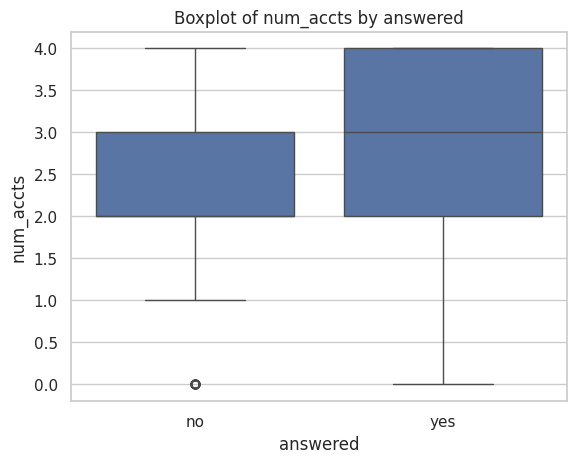

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot
sns.boxplot(x='answered', y='num_accts', data=df)
plt.title('Boxplot of num_accts by answered')
plt.show()

In [43]:
import pandas as pd

# Assuming your DataFrame is called df
df['mobile'] = df['mobile'].astype('category')


In [44]:
# Count the number of occurrences of 'answered' for each 'mobile' category
summary_table = df.groupby(['mobile', 'answered']).size().unstack(fill_value=0)


<ipython-input-44-1e3e1681d6eb>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df.groupby(['mobile', 'answered']).size().unstack(fill_value=0)


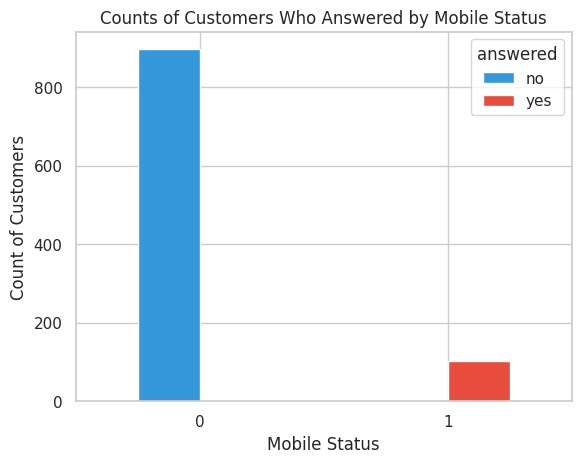

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the barplot of the counts
summary_table.plot(kind='bar', stacked=False, color=["#3498db", "#e74c3c"])

# Set the title and labels
plt.title('Counts of Customers Who Answered by Mobile Status')
plt.xlabel('Mobile Status')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)  # To make the x-axis labels readable

# Show the plot
plt.show()


## Step 4: Modeling

### 4.1: Calculate the base probability of answering

If we use no model at all, how good is our chance of predicting someone leaving?

In [48]:
# prompt: If we use no model at all, how good is our chance of predicting someone leaving?

# Calculate the base probability of answering (assuming 'answered' is your target variable)
base_probability = df['answered'].value_counts(normalize=True)
print(f"Base probability of answering:\n{base_probability}")


Base probability of answering:
answered
no     0.897
yes    0.103
Name: proportion, dtype: float64


### 4.2: Split the training and testing datasets

- split df_clean using train_test_split function
- all variables except answered should be in the x variable
- answered is in the y variable


In [53]:
# prompt: split df_clean using train_test_split function
# all variables except answered should be in the x variable
# answered is in the y variable

# Ensure 'answered' column is present in df_clean (it was likely dropped in earlier steps)
# If 'answered' was a categorical column, you may need to convert it to numerical
if 'answered' not in df_clean.columns:
    df_clean['answered'] = df['answered']  # Assuming 'df' has the 'answered' column
    df_clean['answered'] = df_clean['answered'].cat.codes  # If needed, convert to numerical


x = df_clean.drop('answered', axis=1)
y = df_clean['answered']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

### 4.3: Create a Decision Tree
- Use all available attributes (except those that were eliminated in step 3)
- It is recommended to use the type "entropy" and a max_depth of 4

In [78]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import plot_tree

# Assuming df_clean is already available with the correct data

# Split the data into features (X) and target (y)
X = df_clean.drop('answered', axis=1)  # All features except 'answered'
y = df_clean['answered']  # Target variable 'answered'

# Split the data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create a Decision Tree classifier object with "entropy" criterion and max_depth=4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)





income            0
female            0
age               0
job               0
num_dependents    0
rent              0
own_res           0
new_car           0
chk_acct          0
sav_acct          0
num_accts         0
mobile            0
dtype: int64
0
(700, 12)
(700,)


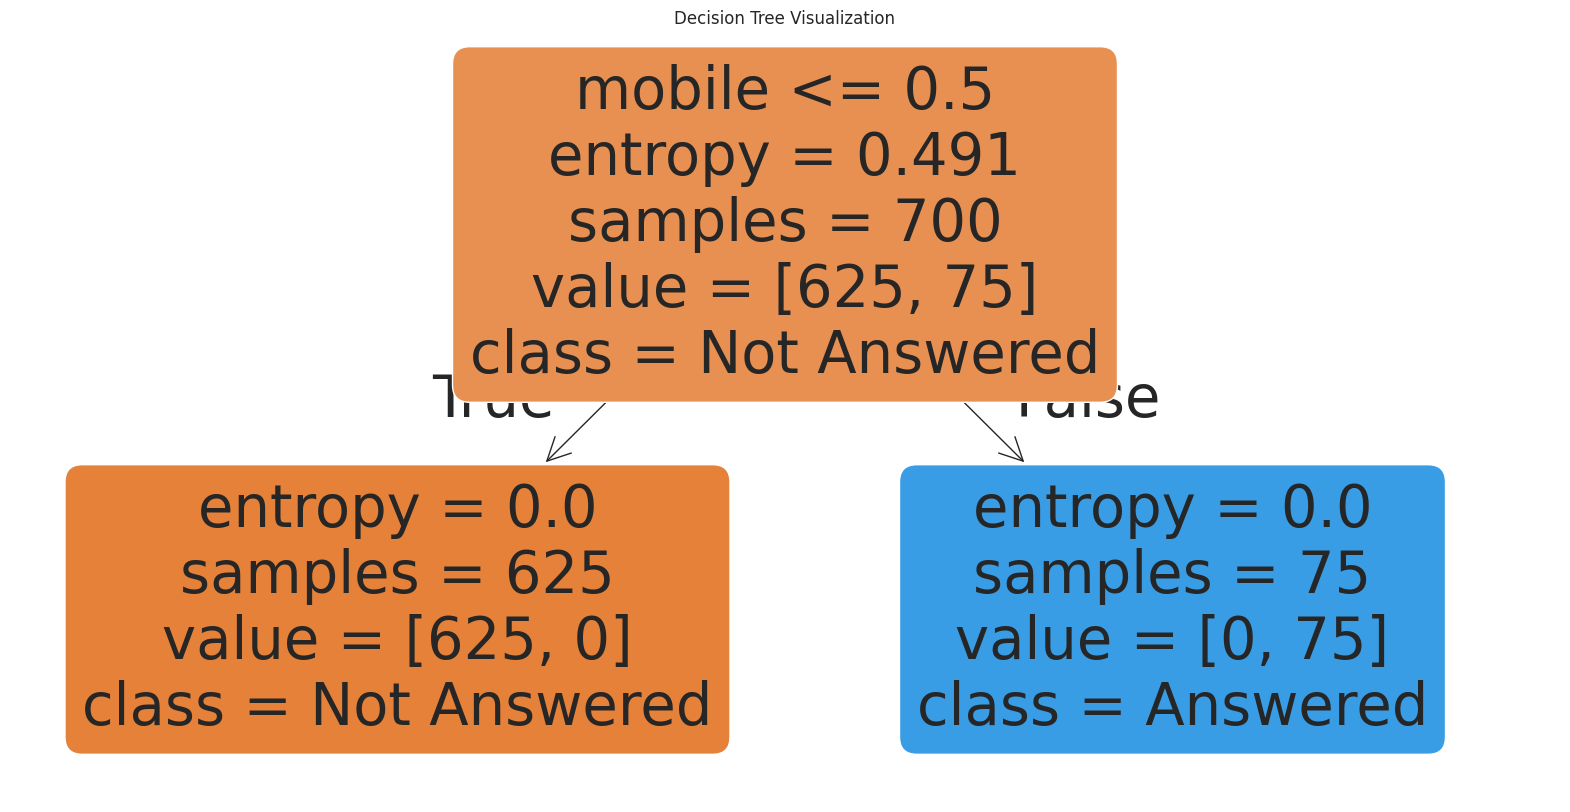

Accuracy: 1.0
Confusion Matrix:
 [[272   0]
 [  0  28]]


In [93]:
# Drop the 'customer_id' column from X since it's not a useful feature for training
X = df_encoded.drop(['answered', 'customer_id'], axis=1)  # Drop both 'answered' and 'customer_id'

# Split the data into features (X) and target (y)
y = df_encoded['answered']  # Target variable 'answered'

# Handle missing values in numeric columns by filling with the mean
numeric_columns = X.select_dtypes(include=['number']).columns  # Get numeric columns
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())  # Fill missing numeric values with the mean

# Handle missing values in categorical columns by filling with the mode (most frequent value)
categorical_columns = X.select_dtypes(exclude=['number']).columns  # Get categorical columns
for column in categorical_columns:
    X[column] = X[column].fillna(X[column].mode()[0])  # Fill missing categorical values with the mode

# Check for missing values again (just for verification)
print(X.isnull().sum())  # Should be all zeros
print(y.isnull().sum())  # Should be zero

# Split the data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Check the shapes of X_train and y_train to ensure they are correct
print(X_train.shape)  # Should be (num_samples, num_features)
print(y_train.shape)  # Should be (num_samples,)

# Create a Decision Tree classifier object with "entropy" criterion and max_depth=4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train the classifier
clf.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Answered', 'Answered'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Optionally: Model evaluation - Accuracy and Confusion Matrix
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


### 4.4: What is the accuracy?

This should be better than the base probability, or you have failed in your objective

Accuracy: 1.0
Confusion Matrix:
 [[272   0]
 [  0  28]]


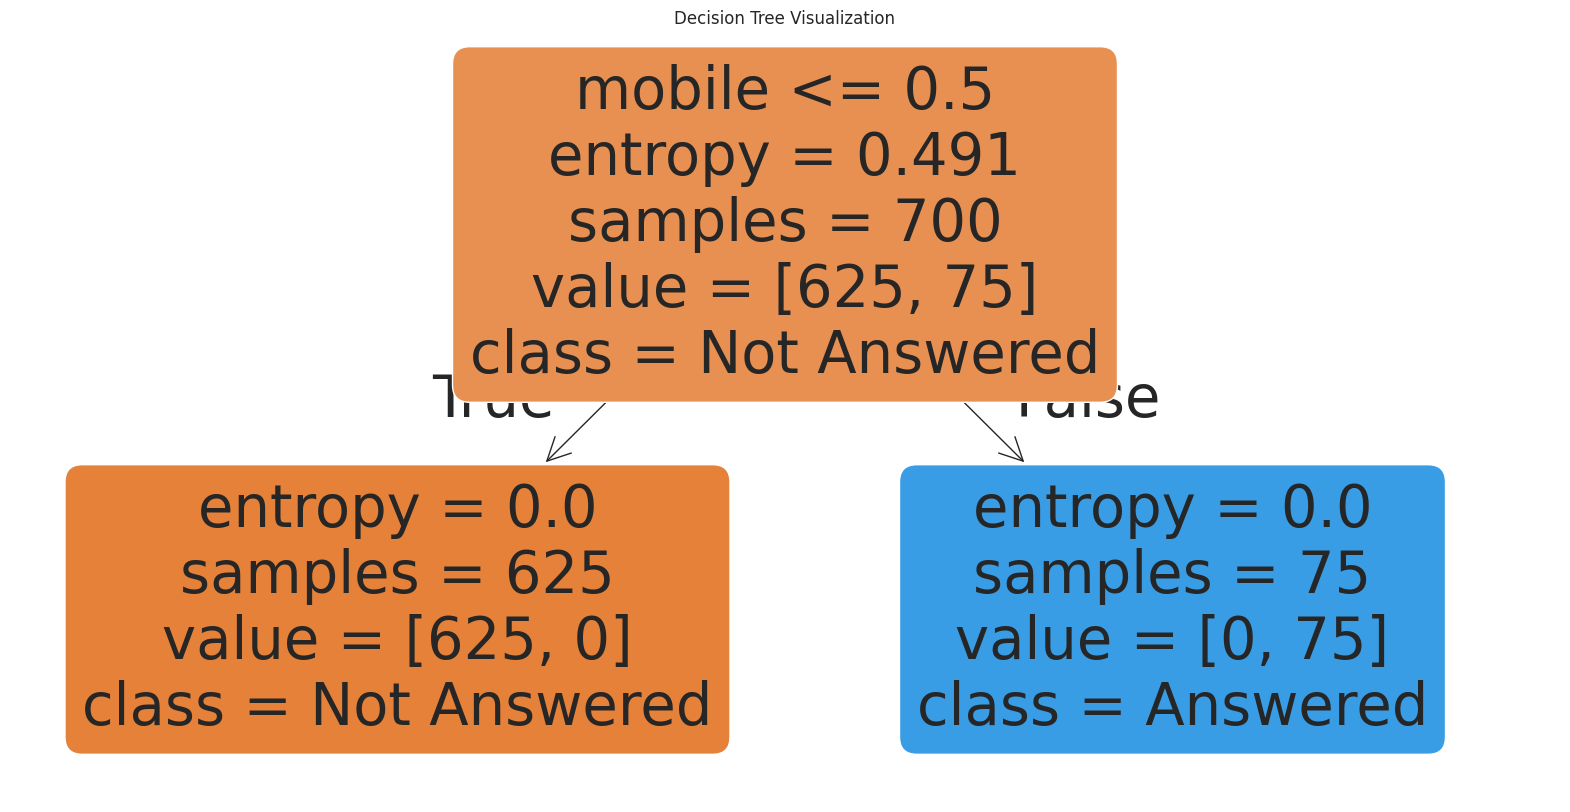

Predicted Probabilities (first 10 test samples):
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [94]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming df_encoded has been preprocessed as shown in previous steps

# Create a copy of df_encoded to avoid modifying the original DataFrame
df_clean = df_encoded.copy()

# Drop 'customer_id' and 'answered' columns from the features set
X = df_clean.drop(['answered', 'customer_id'], axis=1)  # Drop both 'answered' and 'customer_id'
y = df_clean['answered']  # Target variable 'answered'

# Handle missing values in numeric columns by filling with the mean
X.fillna(X.mean(), inplace=True)

# Split the data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create and train the Decision Tree model with entropy criterion and max_depth=4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Answered', 'Answered'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Calculate probabilities for each class (Not Answered or Answered)
y_prob = clf.predict_proba(X_test)

# Print the probabilities for the first 10 test samples
print("Predicted Probabilities (first 10 test samples):")
print(y_prob[:10])  # Displaying the probabilities for the first 10 samples


### 4.5: Create a confusion matrix

This will show false positives, true positives, etc.

Confusion Matrix:
[[272   0]
 [  0  28]]


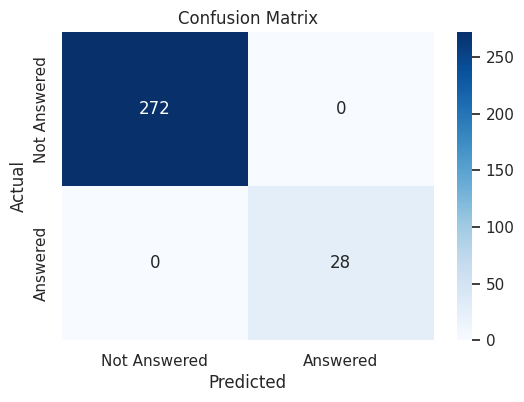

Accuracy: 1.0000


In [95]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clf (trained DecisionTreeClassifier) and X_test, y_test are already available

# Make predictions
y_pred = clf.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Answered", "Answered"], yticklabels=["Not Answered", "Answered"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optionally: Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Create a more visual, interpretable version of the matrix

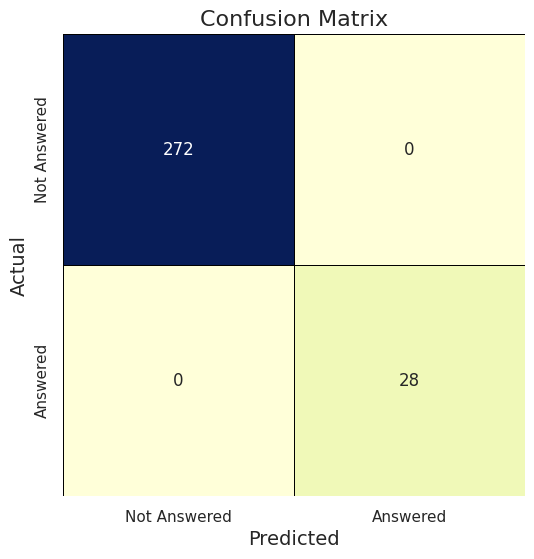

In [96]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already available from the decision tree predictions

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set up the plot
plt.figure(figsize=(8, 6))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, linecolor='black',
            xticklabels=["Not Answered", "Answered"],
            yticklabels=["Not Answered", "Answered"],
            cbar=False, square=True)

# Set labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)

# Show the plot
plt.show()


# Step 5: Evaluate the Model

**Assumptions**

One of the simplifying assumptions we will make in this project is that all the customers who answer the phone will purchase a product. (This assumption is actually verified by the data.) To model "answered" in this case is therefore equivalent to modeling "purchased."

There are costs and benefits in this case. We will assume that customers purchase a product for 100 dollars. This was the average cost of AdviseInvest products, according to the Director of Sales.  Also, as we learned in the interview, the agent time to make the sale is worth 25 dollars. Profit would therefore be \$75 dollars for an answered call and a purchase. In sum:

**Benefit**: True positive. The customer is predicted to answer, does answer, and purchases a product for 100 dollars for a profit of 100 - 25 = 75.

**Cost**: False positive. The customer is predicted to answer, but does not answer, so there is a loss of 25. (We assume the agent cannot schedule another call at the last minute, or spends the entire time slot trying to make the call.)

When you create a calculation you can use:
- True answered * 75 -> These people purchased
- False answered * 25 -> You can't schedule another call

For this exercise, we propose that customers who are not predicted to answer will not be called, so there would be no benefits and no costs for them.  

### 5.1 Calculate the Profit Using the Model

In [97]:
# Assuming y_test and y_pred are already available

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract True Positives (TP) and False Positives (FP)
TP = cm[1, 1]  # True Positives (predicted as answered and actually answered)
FP = cm[0, 1]  # False Positives (predicted as answered but did not answer)

# Calculate the benefit from True Positives
benefit_from_tp = TP * 75  # 75 is the profit per true positive

# Calculate the cost from False Positives
cost_from_fp = FP * 25  # 25 is the cost per false positive

# Calculate total profit
total_profit = benefit_from_tp - cost_from_fp

# Display the results
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"Benefit from True Positives: ${benefit_from_tp}")
print(f"Cost from False Positives: ${cost_from_fp}")
print(f"Total Profit: ${total_profit}")


True Positives (TP): 28
False Positives (FP): 0
Benefit from True Positives: $2100
Cost from False Positives: $0
Total Profit: $2100


### 5.2 Compare to the Default Profit

How much profit (revenue - costs) could be expected if all customers are called? We can consider this a baseline case for profit since it does not require a model.

In other words, to calculate profit in this baseline scenario treat the customers who answer as true positives treat the customers who do not answer as false positives.

In [98]:
# Assuming df_clean contains the actual customer responses and 'answered' is the column that indicates whether a customer answered or not

# Count the number of customers who answered (where 'answered' is 1)
num_answered = df_clean[df_clean['answered'] == 1].shape[0]

# Calculate the total profit (75 dollars for each customer who answered)
total_profit_default = num_answered * 75

# Display the results
print(f"Number of customers who answered: {num_answered}")
print(f"Total Profit without using the model (default): ${total_profit_default}")


Number of customers who answered: 103
Total Profit without using the model (default): $7725


### 5.3 Tune the Model
- Adjust the size or shape of the tree, then test the accuracy
- Continue to make changes until you find a set of hyperparameters that improves the accuracy compared to the initial model

Accuracy: 1.0
Confusion Matrix:
[[272   0]
 [  0  28]]


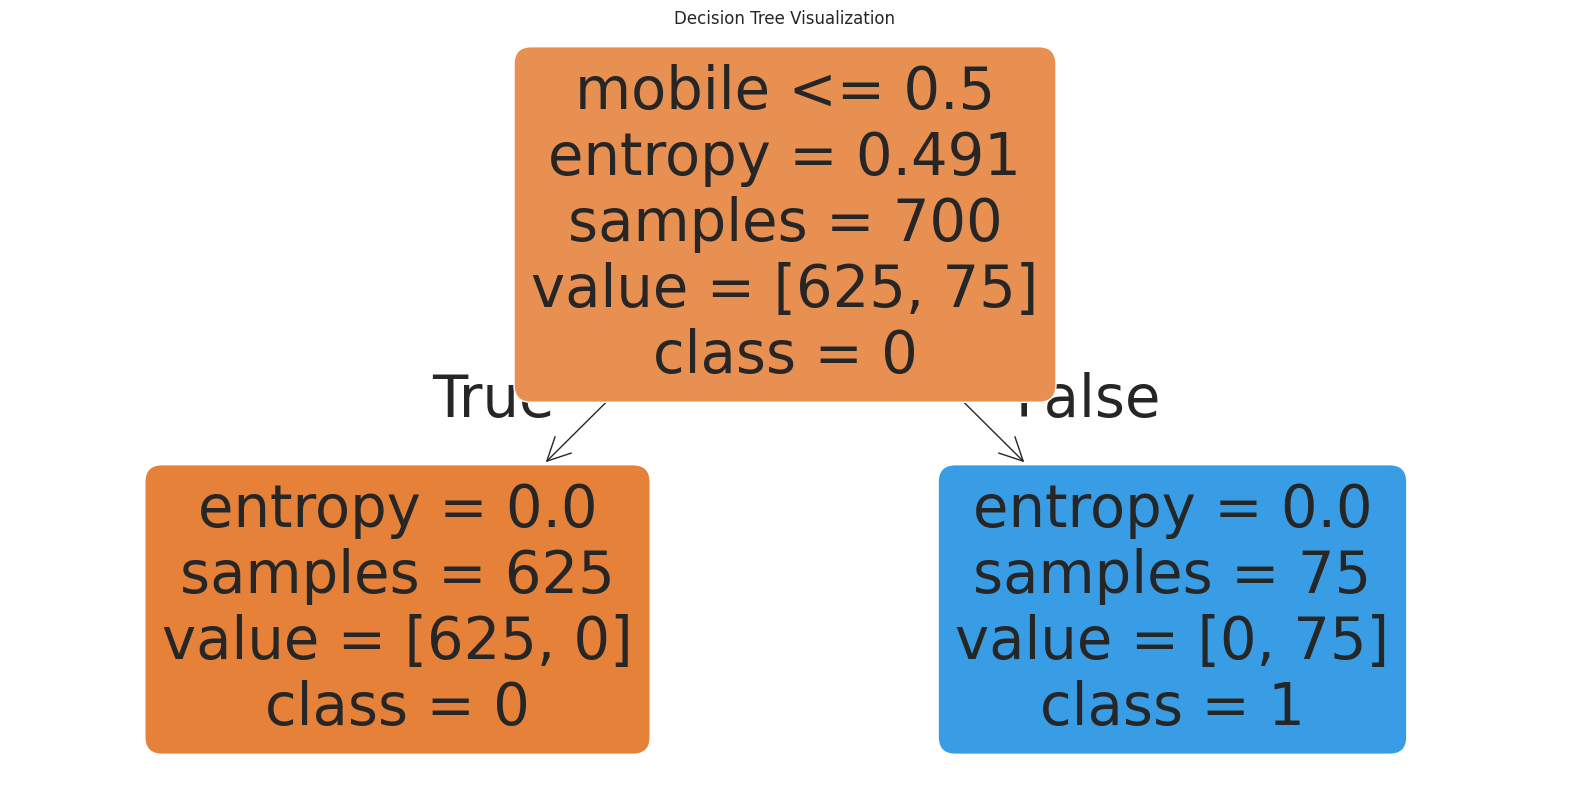

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Assuming df_clean is already loaded with the correct data

# Drop non-predictive columns (e.g., customer_id)
df_clean = df_clean.drop(columns=['customer_id'])

# Convert categorical columns to numerical values
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'product']  # Adjust this based on your dataset
for column in categorical_columns:
    if column in df_clean.columns:
        le = LabelEncoder()
        df_clean[column] = le.fit_transform(df_clean[column].astype(str))

# Handle missing values (optional, but important)
df_clean = df_clean.fillna(df_clean.mean())  # Fill missing values with the mean for numerical columns

# Split the data into features (X) and target (y)
X = df_clean.drop('answered', axis=1)  # Features excluding 'answered'
y = df_clean['answered']  # Target variable 'answered'

# Split the data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create a Decision Tree classifier object with "entropy" criterion and max_depth=4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train the model
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Optionally, visualize the decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


Columns in df_clean: Index(['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res',
       'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile', 'answered'],
      dtype='object')
'customer_id' column not found, skipping drop operation.
Accuracy: 1.0
Confusion Matrix:
[[272   0]
 [  0  28]]
Predicted Probabilities for the first few test samples:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


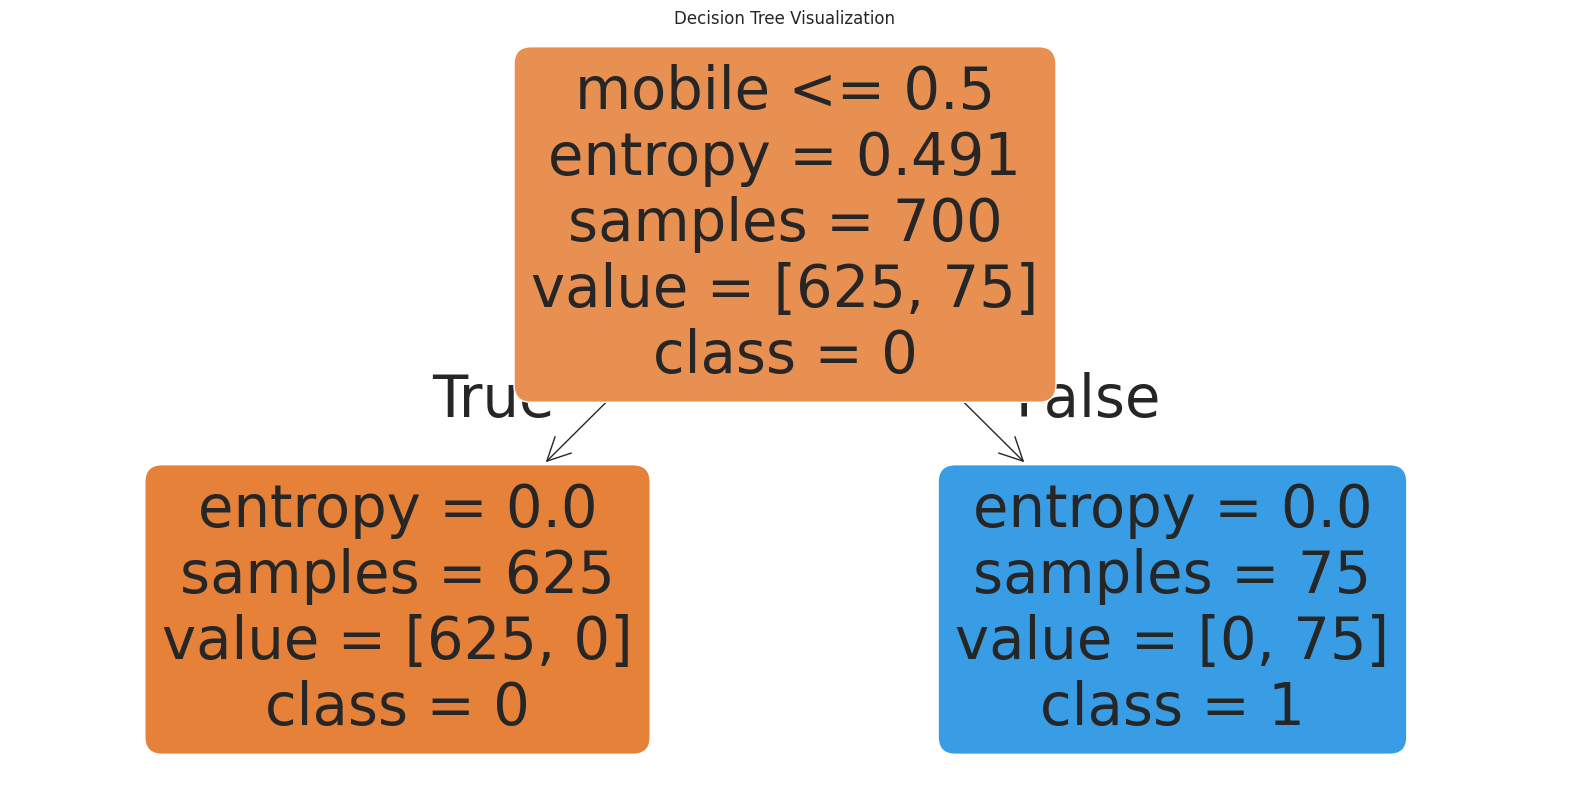

In [103]:
# Check the columns of the DataFrame to see if customer_id is present
print("Columns in df_clean:", df_clean.columns)

# Drop the 'customer_id' column if it exists (if not, this step will be ignored)
if 'customer_id' in df_clean.columns:
    df_clean = df_clean.drop(columns=['customer_id'])
else:
    print("'customer_id' column not found, skipping drop operation.")

# Convert categorical columns to numerical values using Label Encoding
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'product']  # Adjust based on your dataset
for column in categorical_columns:
    if column in df_clean.columns:
        le = LabelEncoder()
        df_clean[column] = le.fit_transform(df_clean[column].astype(str))

# Fill missing values (if any) with the mean value for numerical columns
df_clean = df_clean.fillna(df_clean.mean())

# Split the data into features (X) and target (y)
X = df_clean.drop('answered', axis=1)  # Features excluding 'answered'
y = df_clean['answered']  # Target variable 'answered'

# Split the data into training and testing sets (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create a Decision Tree classifier object with "entropy" criterion and max_depth=4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train the model
clf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Calculate the predicted probabilities for the test dataset
y_prob = clf.predict_proba(X_test)

# Print the first few predicted probabilities
print(f"Predicted Probabilities for the first few test samples:\n{y_prob[:5]}")

# Visualize the decision tree (optional)
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


### 5.4 Apply the Model to New Customers
- Import the "adviseinvest_new_customer_data.csv" file
- Using the tree model, predict each customer for the target variable

In [106]:
import pandas as pd

# Load the dataset directly from the URL
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Assignments/DataSets/adviseinvest_new_customer_data.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

# Check the columns to understand the structure of the data
print(df.columns)




   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0         1   
1   30510       0   54    2               1     0        1        0         0   
2   12880       0   48    2               2     0        1        0         0   
3   15530       0   44    2               1     0        1        0         0   
4   46230       0   40    3               1     0        1        0         3   

   sav_acct  num_accts  mobile customer_id  
0         0          3       0       H1597  
1         0          2       0       P1446  
2         1          4       0       E1492  
3         0          2       0       W5143  
4         1          2       0       W4927  
Index(['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res',
       'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile',
       'customer_id'],
      dtype='object')


In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the dataset from the URL
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Assignments/DataSets/adviseinvest_new_customer_data.csv"
df = pd.read_csv(url)

# Display the first few rows and columns of the dataset
print(df.head())
print(df.columns)

# Convert categorical columns to numeric
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'product']

# Apply LabelEncoder to categorical columns
le = LabelEncoder()

for column in categorical_columns:
    if column in df.columns:
        df[column] = le.fit_transform(df[column].astype(str))  # Ensure the column is treated as strings

# Convert all columns to numeric explicitly (to avoid issues with non-numeric types)
df_clean = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean for numeric columns
df_clean = df_clean.fillna(df_clean.mean())

# Check if 'answered' column is in df_clean
if 'answered' not in df_clean.columns:
    print("'answered' column is missing in df_clean!")
    print("Available columns:", df_clean.columns)
else:
    # Drop 'customer_id' if it exists in the dataset (we don't need it for modeling)
    if 'customer_id' in df_clean.columns:
        df_clean = df_clean.drop(columns=['customer_id'])

    # Split the data into features (X) and target (y)
    X = df_clean.drop('answered', axis=1)  # Features excluding 'answered'
    y = df_clean['answered']  # Target variable 'answered'

    # Split the data into training and testing sets (70% for training, 30% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # Create a Decision Tree classifier object with "entropy" criterion
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

    # Train the model
    clf.fit(X_train, y_train)

    # Predict the response for all customers in the dataset (not just the test set)
    y_pred_all = clf.predict(X)

    # Create a new DataFrame with customer IDs (if available) and their predicted values
    df_predictions = df.copy()
    df_predictions['predicted_answered'] = y_pred_all

    # Filter the customers predicted to answer the call (i.e., predicted_answered == 1)
    customers_predicted_to_answer = df_predictions[df_predictions['predicted_answered'] == 1]

    # Display the DataFrame with customers predicted to answer the call
    print("Customers Predicted to Answer the Call:")
    print(customers_predicted_to_answer[['customer_id', 'predicted_answered']])

    # Optionally: Save the results to a CSV for further analysis
    # customers_predicted_to_answer[['customer_id', 'predicted_answered']].to_csv('predicted_customers.csv', index=False)


   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0         1   
1   30510       0   54    2               1     0        1        0         0   
2   12880       0   48    2               2     0        1        0         0   
3   15530       0   44    2               1     0        1        0         0   
4   46230       0   40    3               1     0        1        0         3   

   sav_acct  num_accts  mobile customer_id  
0         0          3       0       H1597  
1         0          2       0       P1446  
2         1          4       0       E1492  
3         0          2       0       W5143  
4         1          2       0       W4927  
Index(['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res',
       'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile',
       'customer_id'],
      dtype='object')
'answered' column is missing in df_clean!
Available col

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the dataset from the URL
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Assignments/DataSets/adviseinvest_new_customer_data.csv"
df = pd.read_csv(url)

# Display the first few rows and columns of the dataset
print(df.head())
print(df.columns)

# Convert categorical columns to numeric
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'product']

# Apply LabelEncoder to categorical columns
le = LabelEncoder()

for column in categorical_columns:
    if column in df.columns:
        df[column] = le.fit_transform(df[column].astype(str))  # Ensure the column is treated as strings

# Convert all columns to numeric explicitly (to avoid issues with non-numeric types)
df_clean = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean for numeric columns
df_clean = df_clean.fillna(df_clean.mean())

# Check if 'answered' column is in df_clean
if 'answered' not in df_clean.columns:
    print("'answered' column is missing in df_clean!")
    print("Available columns:", df_clean.columns)
else:
    # Drop 'customer_id' if it exists in the dataset (we don't need it for modeling)
    if 'customer_id' in df_clean.columns:
        df_clean = df_clean.drop(columns=['customer_id'])

    # Split the data into features (X) and target (y)
    X = df_clean.drop('answered', axis=1)  # Features excluding 'answered'
    y = df_clean['answered']  # Target variable 'answered'

    # Split the data into training and testing sets (70% for training, 30% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # Create a Decision Tree classifier object with "entropy" criterion
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

    # Train the model
    clf.fit(X_train, y_train)

    # Predict the response for all customers in the dataset (not just the test set)
    y_pred_all = clf.predict(X)

    # Create a new DataFrame with customer IDs (if available) and their predicted values
    df_predictions = df.copy()
    df_predictions['predicted_answered'] = y_pred_all

    # Filter the customers predicted to answer the call (i.e., predicted_answered == 1)
    customers_predicted_to_answer = df_predictions[df_predictions['predicted_answered'] == 1]

    # Display the number of customers predicted to answer the call
    num_customers_predicted_to_answer = len(customers_predicted_to_answer)
    print(f"Number of customers predicted to pick up the call: {num_customers_predicted_to_answer}")


   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0         1   
1   30510       0   54    2               1     0        1        0         0   
2   12880       0   48    2               2     0        1        0         0   
3   15530       0   44    2               1     0        1        0         0   
4   46230       0   40    3               1     0        1        0         3   

   sav_acct  num_accts  mobile customer_id  
0         0          3       0       H1597  
1         0          2       0       P1446  
2         1          4       0       E1492  
3         0          2       0       W5143  
4         1          2       0       W4927  
Index(['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res',
       'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile',
       'customer_id'],
      dtype='object')
'answered' column is missing in df_clean!
Available col

# Step 6: Plan for Deployment
### 6.1: Did we improve our profit using the model?  

Write your conclusion notes below:

I belive the profit will improve using the model. Costs will decrease due to the ability to predict who will anwser and who wont. This will allow sales people to get more customers on the phone. I also belive that the model and data could be used to predict revenue per customer and the types of customers who are calling.

### 6.2: How should the model be deployed?

Write your recommendations below:

The model should be deployed using data from past customers to predict future customers. I belive that the model should be used on a small sample size at first in order to see if it works and then revise it. I would also recomend another coder to check the model to make sure it works and revise it as needed and expand it each time to test the effectivness of deployment.